## Import Statements

In [11]:
from qiskit import *
from qiskit import Aer
from qiskit.circuit.library.standard_gates import HGate
import numpy as np
import matplotlib.pyplot as plt
import itertools
import matplotlib.ticker as ticker
from qiskit.visualization import plot_state_city
from qiskit.providers.ibmq import least_busy
from qiskit.circuit import Parameter
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]
simulator = Aer.get_backend('statevector_simulator')
from qiskit import IBMQ, assemble, transpile
import qiskit.quantum_info as qi

provider = IBMQ.load_account()
provider.backends(simulator=False, operational=True)
small_devices = provider.backends(filters=lambda x: x.configuration().n_qubits == 5
                                   and not x.configuration().simulator)
small_devices

ibmqfactory.load_account:WARNING:2021-07-06 14:43:06,072: Credentials are already in use. The existing account in the session will be replaced.


[<IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>]

## Function Definitions

In [62]:
def Fgate(k,N):
    qcirc = QuantumCircuit(2,name="F_{:}".format(k))
    qcirc.rz(2*np.pi*k/N,1)
    qcirc.cx(1,0)
    qcirc.ch(0,1)
    qcirc.cx(1,0)
    qcirc.cz(1,0)
    return(qcirc.to_instruction())

def Fdgate(k,N):
    qcirc = QuantumCircuit(2,name="F+_{:}".format(k))
    qcirc.cz(1,0)
    qcirc.cx(1,0)
    qcirc.ch(0,1)
    qcirc.cx(1,0)
    qcirc.rz(-2*np.pi*k/N,1)
    return(qcirc.to_instruction())

def fSWAP():
    qcirc = QuantumCircuit(2,name="fSWAP")
    qcirc.cx(0,1)
    qcirc.cx(1,0)
    qcirc.cx(0,1)
    qcirc.h(1)
    qcirc.cx(0,1)
    qcirc.h(1)
    return(qcirc.to_instruction())

# fSWAP = ["s",q1,q2]
# F-Gate = ["f",q1,q2,k]
# Fdagger-Gate = ["fd",q1,q2,k]
def listAppend(orderedlist,qc):
    N = len(qc.qubits)
    for i in orderedlist:
        if(i[0] == "s" and len(i) == 3):
            qc.append(fSWAP(),[i[1],i[2]])
        elif(i[0] == "f" and len(i) == 4):
            qc.append(Fgate(i[3],N),[i[1],i[2]])
        elif(i[0] == "fd" and len(i) == 4):
            qc.append(Fdgate(i[3],N),[i[1],i[2]])
        else:
            print("Failed circuit instruction: {:}".format(i))

# fFT methods assume qubits come in like ++-- (N=4) or ++++---- (N=8) and return qubits like +-+- (N=4) or +-+-+-+- (N=8). #
def fFT4():
    N=4
    qcirc = QuantumCircuit(4,name="U+_fFT")
    list = [["fd",0,1,0],["fd",2,3,0],["s",1,2]]
    listAppend(list,qcirc)
    qcirc.draw()
    return(qcirc.to_instruction())

def fFT8():
    N=8
    qcirc = QuantumCircuit(8,name="U+_fFT")
    list = [["fd",0,1,1],["fd",2,3,0],["s",1,2],["fd",0,1,0],["fd",2,3,0],["fd",4,5,1],["fd",6,7,0],["s",5,6],["fd",4,5,0],["fd",6,7,0],["s",3,4],["s",2,3],["s",4,5],["s",1,2],["s",3,4],["s",5,6]]
    listAppend(list,qcirc)
    qcirc.draw()
    return(qcirc.to_instruction())

## Implements exp( -i/2*(thetax XX + thetay YY + thetaz ZZ))
def pauliExp(thetax = 0,thetay = 0,thetaz = 0):
    qcirc = QuantumCircuit(2,name="XX: {:}, YY: {:}, ZZ: {:}".format(thetax,thetay,thetaz))
    qcirc.cx(0,1)
    if(thetax != 0):
        qcirc.rx(thetax,0)
    if(thetaz != 0):
        qcirc.rz(thetaz,1)
    qcirc.h(0)
    qcirc.cx(0,1)
    if(thetaz != 0):
        qcirc.rz(-thetay,1)
    qcirc.s(0)
    qcirc.h(0)
    qcirc.cx(0,1)
    qcirc.rx(-np.pi/2,0)
    qcirc.rx(np.pi/2,1)
    return(qcirc.to_instruction())

def bogT(q,N,m):
    alpha = -2.0*np.pi*q/N
    omega = np.sqrt(m**2 + np.cos(-alpha)**2)
    beta = np.arctan( np.sqrt( (omega-m)/(omega+m) ) )
    theta2 = -alpha - np.pi/2
    theta3 = alpha/2
    theta4 = beta
    theta5 = -alpha/2
    theta6 = 1/2*(np.pi - alpha)
    qcirc = QuantumCircuit(2,name="B")
    qcirc.rz(theta6,0)
    qcirc.rz(theta5,1)
    qcirc.append(pauliExp(theta4,theta4,theta3),[0,1])
    qcirc.rz(theta2,1)
    qcirc.draw("mpl")
    return(qcirc.to_instruction())

In [84]:
def swapladder(qubits):
    N = len(qubits)
    qcirc = QuantumCircuit(N,name="SwapLadder({:})".format(N))
    for i in range(int(N/2)-1):
        orderedlist = []
        for k in range(i+1):
            orderedlist = orderedlist + [["s",int(N/2) - 1 + i - 2*k,int(N/2) + i - 2*k]]
        listAppend(orderedlist,qcirc)
    return(qcirc.to_instruction())

def FFT(qubits,N):
    n = len(qubits)
    qcirc = QuantumCircuit(n,name="U+_fFT")
    if n % 2 > 0:
        print("Number of particle or antiparticle qubits must be a power of 2")
    elif n==2: #IF N=2, DFT
        qcirc.append(Fgate(0),qubits)
    else:
        1

def CRZD(theta,control_qubit,target_qubit,circuit):
    circuit.rz(theta/2,target_qubit)
    circuit.cx(control_qubit,target_qubit)
    circuit.rz(-theta/2,target_qubit)
    circuit.cx(control_qubit,target_qubit)

    ###################### WIP ######################
def fFT(circuit, qubits):
    qcirc = QuantumCircuit(len(qubits),name="U+_fFT")
    N = len(qubits)
    if N % 2 > 0:
        print("N must be divisible by 2 for fFT")
    particles = qubits[:int(N/2)]
    antiparticles = qubits[int(N/2):]
    qcirc.append(FFT(particles),particles)
    qcirc.append(FFT(antiparticles),antiparticles)
        

## Check U_fFT Gate Compositions

In [11]:
qc = QuantumCircuit(8)
qr = QuantumRegister(8)
qc.append(swapladder([0,1,2,3,4,5,6,7]),[0,1,2,3,4,5,6,7])
qc.draw()

┌────────────────┐
q_0: ┤0               ├
     │                │
q_1: ┤1               ├
     │                │
q_2: ┤2               ├
     │                │
q_3: ┤3               ├
     │  SwapLadder(8) │
q_4: ┤4               ├
     │                │
q_5: ┤5               ├
     │                │
q_6: ┤6               ├
     │                │
q_7: ┤7               ├
     └────────────────┘

In [12]:
qcirc = QuantumCircuit(4,name="U+_fFT")
list = [["fd",0,1,0],["fd",2,3,0],["s",1,2]]
listAppend(list,qcirc)
qcirc.draw()

┌───────┐          
q_0: ┤0      ├──────────
     │  F+_0 │┌────────┐
q_1: ┤1      ├┤0       ├
     ├───────┤│  fSWAP │
q_2: ┤0      ├┤1       ├
     │  F+_0 │└────────┘
q_3: ┤1      ├──────────
     └───────┘

In [15]:
qc = QuantumCircuit(8)
qr = QuantumRegister(8)
qc.append(fFT8(),[0,1,2,3,4,5,6,7])
qc.draw()

┌─────────┐
q_0: ┤0        ├
     │         │
q_1: ┤1        ├
     │         │
q_2: ┤2        ├
     │         │
q_3: ┤3        ├
     │  U+_fFT │
q_4: ┤4        ├
     │         │
q_5: ┤5        ├
     │         │
q_6: ┤6        ├
     │         │
q_7: ┤7        ├
     └─────────┘

## Decomposition

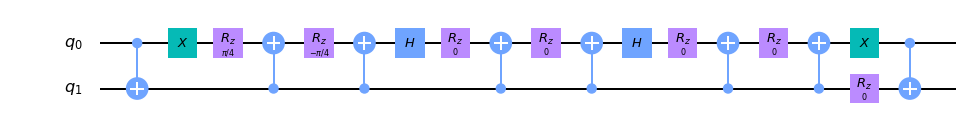

In [90]:
## OLD SCHEME FOR B NOT OPTIMIZED
qc = QuantumCircuit(2)
qc.cx(0,1)
qc.x(0)
CRZD(np.pi/2,1,0,qc)
qc.h(0)
CRZD(0,1,0,qc)
qc.h(0)
CRZD(0,1,0,qc)
qc.rz(0,1) #double coefficient
qc.x(0)
qc.cx(0,1)
qc.draw("mpl")

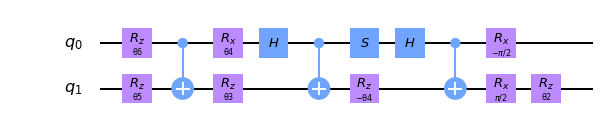

In [23]:
qcirc = QuantumCircuit(2)
theta6 = Parameter('θ6')
theta5 = Parameter('θ5')
theta2 = Parameter('θ2')
theta4 = Parameter('θ4')
theta3 = Parameter('θ3')
mtheta4 = Parameter('-θ4')
qcirc.rz(theta6,0)
qcirc.rz(theta5,1)
qcirc.cx(0,1)
qcirc.rx(theta4,0)
qcirc.rz(theta3,1)
qcirc.h(0)
qcirc.cx(0,1)
qcirc.rz(mtheta4,1)
qcirc.s(0)
qcirc.h(0)
qcirc.cx(0,1)
qcirc.rx(-np.pi/2,0)
qcirc.rx(np.pi/2,1)

qcirc.rz(theta2,1)
qcirc.draw("mpl")
